# XGBoostRegression Year column embedding
    1. Year column embedding code to preserve time series properties.
    2. stock별 시계열패턴을 모델이 학습할수 있도록 작성된 코드.

In [2]:
import pandas as pd
from xgboost import XGBRegressor

model = XGBRegressor(enable_categorical=True, tree_method = "hist", device = "cuda")
model

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,'cuda'
,early_stopping_rounds,None
,enable_categorical,True
,eval_metric,None


In [3]:
# Set target_columns
target_columns = ['CETR', 'GETR', 'TSTA', 'TSDA']

In [4]:
# Load CSV file
df = pd.read_csv('data.csv')
df

,name,stock,year,KOSPI,fnd_year,fiscal,ind,big4,forn,own,...,GETR5,CETR5,TSTA,TSDA,A_GETR,A_CETR,A_GETR3,A_CETR3,A_GETR5,A_CETR5
0,동화약품,20,2013,1,1897,12,21,1,0.0613,0.3114,...,0.294414,0.266121,-0.071863,-0.088363,-0.236479,0.748503,0.058765,-0.096756,0.034497,-0.019779
1,동화약품,20,2014,1,1897,12,21,1,0.0502,0.3151,...,0.233461,0.418783,-0.001226,-0.014614,-0.150710,0.748503,0.500993,0.733432,-0.026455,0.132883
2,동화약품,20,2015,1,1897,12,21,1,0.0749,0.3235,...,0.231593,0.528209,0.072994,0.056283,-0.171420,-0.024525,-0.195255,0.733432,-0.028324,0.242310
3,동화약품,20,2016,1,1897,12,21,1,0.0746,0.3229,...,0.306044,0.325968,0.106756,0.107570,0.026917,-0.194237,-0.174602,0.327249,0.046128,0.040069
4,동화약품,20,2017,1,1897,12,21,1,0.1186,0.3240,...,0.250474,0.216419,-0.061506,0.008744,0.042469,-0.157749,-0.014648,-0.184860,-0.009442,-0.069481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12648,잉글우드랩,950140,2023,0,2015,12,20,0,0.1248,0.4408,...,0.174191,0.211668,-0.317902,-0.362904,-0.122071,0.080095,-0.064306,0.002523,0.001916,0.012473
12649,잉글우드랩,950140,2024,0,2015,12,20,0,0.1358,0.4408,...,0.114758,0.256242,-0.358287,-0.384294,-0.123269,0.292943,-0.129741,0.004858,-0.091928,0.027420
12650,고스트스튜디오,950190,2022,0,2016,12,58,1,0.1374,0.4427,...,0.176417,0.172354,-0.109588,-0.137899,-0.055951,-0.122758,-0.039628,0.121765,-0.064150,-0.092251
12651,고스트스튜디오,950190,2023,0,2016,12,58,1,0.1445,0.5158,...,0.180101,0.204584,-0.225762,-0.237668,-0.034687,-0.052817,-0.041439,-0.021230,-0.060466,-0.060022


In [5]:
# Set categorical_cols
categorical_cols = ['name', 'stock', 'KOSPI', 'big4', 'LOSS', 'ind']
for col in categorical_cols:
    df[col] = df[col].astype('category')

print(df.dtypes)

name        category
stock       category
year           int64
KOSPI       category
fnd_year       int64
              ...   
A_CETR       float64
A_GETR3      float64
A_CETR3      float64
A_GETR5      float64
A_CETR5      float64
Length: 65, dtype: object


In [6]:
# Set target column
## drop 'object' dtype
X = df.drop(columns=['name'] + target_columns, axis=1)
y = df[target_columns]
X.shape, y.shape

((12653, 60), (12653, 4))

In [7]:
# Time-series aware encoding & global cutoff split (2011~2023 train, 2024 test)
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error

# 1. Year 기반 전역/종목별 트렌드 & 주기 인코딩
year_min = df['year'].min()
year_max = df['year'].max()

# 전역 정규화 (0~1)
df['year_norm_global'] = (df['year'] - year_min) / (year_max - year_min)

# 종목별 시작 기준 index (0부터 증가)
df['year_index_stock'] = df.groupby('stock')['year'].rank(method='dense').astype(int) - 1
# 종목별 상대적 진행도 (0~1)
df['year_norm_stock'] = df['year_index_stock'] / df.groupby('stock')['year_index_stock'].transform('max')

# 주기성 (사이클) 표현: 한 전체 구간(2011~2024)을 하나의 2π 주기로 가정
angle = 2 * np.pi * df['year_norm_global']
df['year_sin'] = np.sin(angle)
df['year_cos'] = np.cos(angle)

# 2. Lag 특징 (1-step lag) 생성: 수치형 컬럼 대상으로 종목별 shift(1)
exclude_for_lag = set(['name', 'stock', 'year'] + target_columns)
num_cols_for_lag = [c for c in df.columns if c not in exclude_for_lag and df[c].dtype.kind in ['i','u','f']]
for col in num_cols_for_lag:
    df[f'{col}_lag1'] = df.groupby('stock', observed=True)[col].shift(1)

# 3. 전역 컷오프 기반 연도 분리 (Train: <=2023, Test: 2024)
CUTOFF_TEST_YEAR = 2024
train_mask = df['year'] < CUTOFF_TEST_YEAR
full_test_mask = df['year'] == CUTOFF_TEST_YEAR

train_df = df[train_mask].copy()
test_df = df[full_test_mask].copy()

# 4. 2024 테스트셋: 과거(2011~2023) 기록이 있는 종목만 사용 (seen stocks)
seen_stocks = set(train_df['stock'].unique())
seen_test_df = test_df[test_df['stock'].isin(seen_stocks)].copy()

# 5. 특징/타겟 분리 함수
def split_Xy(dataframe):
    X_ = dataframe.drop(columns=['name', 'stock'] + target_columns)
    y_ = dataframe[target_columns]
    return X_, y_

X_train, y_train = split_Xy(train_df)
X_test_seen, y_test_seen = split_Xy(seen_test_df)
# 호환성(아래 다른 셀에서 X_test / y_test 이름을 사용할 수 있으므로 별칭 제공)
X_test, y_test = X_test_seen, y_test_seen

# 6. Lag 결측 처리 (lag1 최초 연도 NaN 등) - 학습셋 중앙값 기준
lag_cols = [c for c in X_train.columns if c.endswith('_lag1')]
if lag_cols:
    lag_medians = X_train[lag_cols].median()
    X_train[lag_cols] = X_train[lag_cols].fillna(lag_medians)
    X_test_seen[lag_cols] = X_test_seen[lag_cols].fillna(lag_medians)

print(f"Train years: {int(train_df['year'].min())}-{int(train_df['year'].max())} | Test year: {CUTOFF_TEST_YEAR}")
print(f"Seen stocks count: {len(seen_stocks)}")
print("Shapes -> Train:", X_train.shape, "SeenTest:", X_test_seen.shape)
print("Lag feature count:", len(lag_cols))
print("Sample feature cols:", X_train.columns[:10].tolist())

Train years: 2011-2023 | Test year: 2024
Seen stocks count: 1693
Shapes -> Train: (11567, 123) SeenTest: (1025, 123)
Lag feature count: 59
Sample feature cols: ['year', 'KOSPI', 'fnd_year', 'fiscal', 'ind', 'big4', 'forn', 'own', 'c_asset', 'inv']


/tmp/ipykernel_3237452/3450631170.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['year_index_stock'] = df.groupby('stock')['year'].rank(method='dense').astype(int) - 1
/tmp/ipykernel_3237452/3450631170.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['year_norm_stock'] = df['year_index_stock'] / df.groupby('stock')['year_index_stock'].transform('max')


In [ ]:
# 7. 모델 학습 & 평가 (Seen stocks 2024만)
model.fit(X_train, y_train)

pred_seen = model.predict(X_test_seen)
print('[Seen Stocks 2024] R2:', r2_score(y_test_seen, pred_seen),
      'MAE:', mean_absolute_error(y_test_seen, pred_seen),
      'RMSE:', root_mean_squared_error(y_test_seen, pred_seen))

# 타겟별 상세
print('\nPer-target metrics:')
for i, col in enumerate(target_columns):
    r2_i = r2_score(y_test_seen[col], pred_seen[:, i])
    mae_i = mean_absolute_error(y_test_seen[col], pred_seen[:, i])
    rmse_i = root_mean_squared_error(y_test_seen[col], pred_seen[:, i])
    print(f"  {col}: R2={r2_i:.4f} MAE={mae_i:.4f} RMSE={rmse_i:.4f}")

# importance
fi = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print('\nTop 25 Feature Importances:')
print(fi.head(25))

[Seen Stocks 2024] R2: 0.9624375700950623 MAE: 0.024534743279218674 RMSE: 0.04325372725725174

Per-target metrics:
  CETR: R2=0.9957 MAE=0.0100 RMSE=0.0147
  GETR: R2=0.9878 MAE=0.0097 RMSE=0.0150
  TSTA: R2=0.9380 MAE=0.0376 RMSE=0.0686
  TSDA: R2=0.9282 MAE=0.0409 RMSE=0.0748

Top 25 Feature Importances:
SIZE                0.361371
lag_asset           0.217284
A_CETR              0.106536
year                0.084622
A_GETR              0.043158
asset               0.022695
ocf                 0.021374
CFO                 0.011985
fnd_year            0.010048
lag1_ni             0.009259
sales               0.006879
AGE                 0.006653
equit               0.005734
pti                 0.004822
MB_lag1             0.004747
ROA                 0.003802
ROE                 0.003670
lag_sales           0.003250
ni                  0.002621
equit_lag1          0.002412
KOSPI               0.002152
lag_c_asset_lag1    0.002094
c_liab_lag1         0.002088
GETR5               0.001

/home/super/.local/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [13:27:20] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


            R2       MAE      RMSE
CETR  0.995734  0.010002  0.014709
GETR  0.987818  0.009660  0.014950
TSTA  0.937962  0.037624  0.068559
TSDA  0.928236  0.040852  0.074797


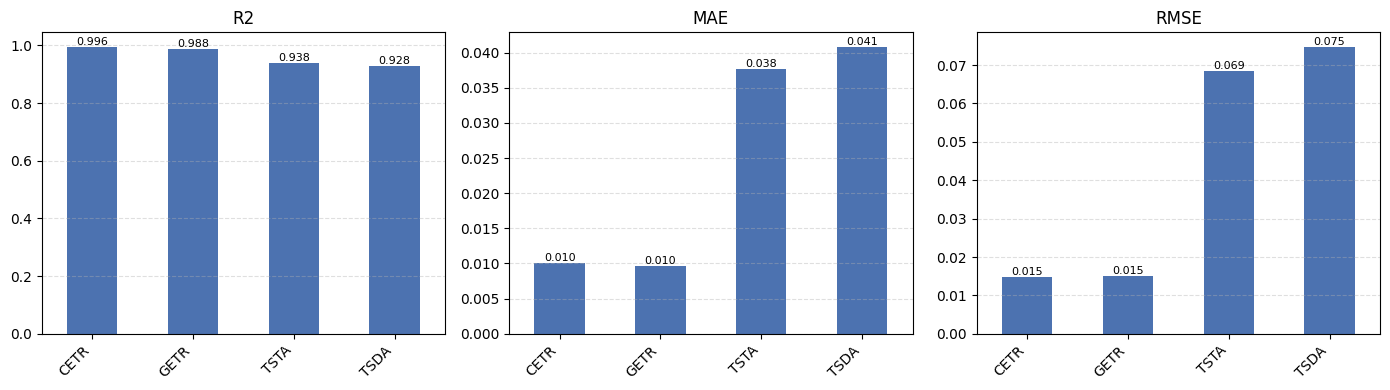

In [11]:
import matplotlib.pyplot as plt

# 타겟별 성능지표 계산
metrics = {'R2': [], 'MAE': [], 'RMSE': []}
for i, col in enumerate(target_columns):
    y_true = y_test_seen[col]
    y_pred = pred_seen[:, i]
    metrics['R2'].append(r2_score(y_true, y_pred))
    metrics['MAE'].append(mean_absolute_error(y_true, y_pred))
    metrics['RMSE'].append(root_mean_squared_error(y_true, y_pred))

metrics_df = pd.DataFrame(metrics, index=target_columns)
print(metrics_df)

# 시각화
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
for ax, metric in zip(axes, metrics_df.columns):
    axes_idx = metrics_df[metric].plot(kind='bar', ax=ax, color='#4C72B0')
    ax.set_title(metric)
    ax.set_xticklabels(metrics_df.index, rotation=45, ha='right')
    ax.grid(axis='y', linestyle='--', alpha=0.4)
    for p in ax.patches:
        val = p.get_height()
        ax.annotate(f'{val:.3f}', (p.get_x() + p.get_width()/2, val),
                    ha='center', va='bottom', fontsize=8, rotation=0)
plt.tight_layout()
plt.show()

In [13]:
# 8. 결과 저장 (Seen test)
import numpy as np
results_df = pd.DataFrame(
    data = np.hstack([y_test_seen.values, pred_seen]),
    columns = [f'actual_{col}' for col in y_test_seen.columns] + [f'pred_{col}' for col in y_test_seen.columns],
    index = y_test_seen.index,
)
results_df.to_csv('actual_vs_predicted_seen_2024.csv', index=True)
print('Saved: actual_vs_predicted_seen_2024.csv')

# Per-target metrics 저장
metric_rows = []
for i, col in enumerate(target_columns):
    metric_rows.append({
        'target': col,
        'R2': r2_score(y_test_seen[col], pred_seen[:, i]),
        'MAE': mean_absolute_error(y_test_seen[col], pred_seen[:, i]),
        'RMSE': root_mean_squared_error(y_test_seen[col], pred_seen[:, i])
    })
metrics_df = pd.DataFrame(metric_rows)
metrics_df.to_csv('xgboost_metrics_seen_2024.csv', index=False)
print('Saved: xgboost_metrics_seen_2024.csv')

Saved: actual_vs_predicted_seen_2024.csv
Saved: xgboost_metrics_seen_2024.csv


## Reference site
    지표 및 점수
    https://scikit-learn.org/stable/modules/model_evaluation.html#model-evaluation
    https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics
